# GLOBAL SOLUTION


DATASET EM: https://www.kaggle.com/datasets/arashnic/hr-ana



## Objetivo do Projeto

Este notebook detalha o desenvolvimento de um modelo de **classificação supervisionada** com o objetivo principal de prever se um funcionário será promovido ou não (a variável-alvo **`is_promoted`**).

Utilizando um conjunto de dados de RH, o modelo será treinado para aprender padrões com base no perfil de cada funcionário, incluindo seu departamento, avaliações de desempenho anteriores, número de treinamentos e pontuação média, para identificar os fatores que mais influenciam uma promoção.

## Relação com o "Futuro do Trabalho"

Este projeto se conecta diretamente ao tema do "Futuro do Trabalho" ao aplicar a ciência de dados em um processo de RH tradicionalmente subjetivo. Em vez de depender apenas da intuição, o modelo oferece uma ferramenta analítica para:

* **Identificar Talentos:** Descobrir funcionários com alto potencial que podem ter sido esquecidos pelo gerenciamento.
* **Tomada de Decisão Baseada em Dados:** Auxiliar gestores a tomar decisões de promoção mais justas, transparentes e imparciais.
* **Validar Habilidades (Upskilling):** Entender quantitativamente o impacto real que os treinamentos (`avg_training_score`) e o desempenho (`previous_year_rating`) têm na progressão de carreira dentro da organização.

## Metodologia

O pipeline a seguir irá cobrir todas as etapas do processo de machine learning:

1.  **Carregamento e Limpeza** dos dados (baixados via KaggleHub).
2.  **Análise Exploratória (EDA)** para entender as variáveis.
3.  **Pré-processamento** (Scaling, Imputação e Encoding) usando `Pipelines` para garantir a integridade dos dados e evitar *data leakage*.
4.  **Treinamento** de múltiplos modelos, incluindo:
    * `LogisticRegression` (como baseline).
    * `RandomForestClassifier` (para performance e interpretabilidade).
5.  **Tuning de Hiperparâmetros** com `RandomizedSearchCV` (testando `XGBoost`, `LightGBM` e `HistGradientBoosting` se disponíveis).
6.  **Avaliação** final e apresentação dos resultados.

----

## 1. Bibliotecas



In [1]:
import os, zipfile, datetime, traceback
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub  
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Bibliotecas de Boosting (serão importadas dentro do 'try')
# import xgboost as xgb
# import lightgbm as lgb

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


----

## 3. Carregamento e organização
O código abaixo carrega o arquivo contido em ("https://www.kaggle.com/datasets/arashnic/hr-ana") e separa a base em treino e teste


    # Varíaveis de configuração

In [2]:
RANDOM_STATE = 42
CSV_TRAIN = "train.csv"  
CSV_TEST = "test.csv"    

    # Carregamento:

In [3]:
# CARREGAR DADOS (KaggleHub)
print("Baixando dataset 'arashnic/hr-ana' do KaggleHub...")
try:
    path = kagglehub.dataset_download("arashnic/hr-ana")
    print(f"Dataset baixado para o diretório: {path}")

    # --- Carregar TREINO ---
    full_file_path_train = os.path.join(path, CSV_TRAIN)
    df_train = pd.read_csv(full_file_path_train)
    print(f"--- DataFrame de TREINO carregado com sucesso ({df_train.shape[0]} linhas) ---")

    # --- Carregar TESTE ---
    full_file_path_test = os.path.join(path, CSV_TEST)
    df_test = pd.read_csv(full_file_path_test)
    print(f"--- DataFrame de TESTE carregado com sucesso ({df_test.shape[0]} linhas) ---")

except Exception as e:
    print(f"\nERRO ao baixar ou carregar os arquivos: {e}")

Baixando dataset 'arashnic/hr-ana' do KaggleHub...
Dataset baixado para o diretório: C:\Users\loren\.cache\kagglehub\datasets\arashnic\hr-ana\versions\1
--- DataFrame de TREINO carregado com sucesso (54808 linhas) ---
--- DataFrame de TESTE carregado com sucesso (23490 linhas) ---


    #  Preparação x/y:

In [4]:
# --- Preparar dados de TREINO  ---
print("Preparando X_train e y_train (do arquivo de treino)...")
df_train.columns = [c.strip().lower().replace(' ', '_') for c in df_train.columns]
if 'employee_id' in df_train.columns:
    X_train = df_train.drop(columns=['is_promoted','employee_id'])
else:
    X_train = df_train.drop(columns=['is_promoted'])
y_train = df_train['is_promoted']

# --- Preparar dados de TESTE ---
print("Preparando X_test (do arquivo de teste)...")
df_test.columns = [c.strip().lower().replace(' ', '_') for c in df_test.columns]

# Salva o employee_id para o arquivo de submissão
if 'employee_id' in df_test.columns:
    test_employee_ids = df_test['employee_id'] # Salva para depois
    X_test = df_test.drop(columns=['employee_id'])
else:
    X_test = df_test # Assume que não tem 'is_promoted'
    test_employee_ids = None # Não temos IDs

print(f"Dados prontos: {X_train.shape[0]} amostras de treino, {X_test.shape[0]} amostras de teste.")
print("AVISO: 'y_test' (respostas do teste) não foi criado, pois 'is_promoted' não existe no test.csv.")

Preparando X_train e y_train (do arquivo de treino)...
Preparando X_test (do arquivo de teste)...
Dados prontos: 54808 amostras de treino, 23490 amostras de teste.
AVISO: 'y_test' (respostas do teste) não foi criado, pois 'is_promoted' não existe no test.csv.


----

## 4. PRÉ-PROCESSAMENTO



    # Definições e melhorias em colunas

In [5]:
# Define quais colunas são numéricas e quais são categóricas
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Pipeline para dados numéricos: preenche faltantes com mediana, depois normaliza
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para dados categóricos: preenche faltantes com moda, depois aplica One-Hot Encoding sem matriz esparsa
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # <-- ADICIONE ISTO
])

# Junta os dois pipelines em um único pré-processador
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])
print("Pipeline de pré-processamento definido.")

results = {}

Pipeline de pré-processamento definido.


---
## 5. LOGISTIC REGRESSION


In [6]:
print("Treinando Modelo 1: Regressão Logística (Baseline)...")
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# TREINA O MODELO (usando X_train e y_train)
pipe_lr.fit(X_train, y_train)

print("Regressão Logística concluída.")

Treinando Modelo 1: Regressão Logística (Baseline)...
Regressão Logística concluída.


---
## 6. RANDOM FOREST


In [7]:

# --- RandomForest e Feature Importance ---
print("\nTreinando Modelo 2: RandomForest (pode levar alguns minutos)...")
pipe_rf_full = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=RANDOM_STATE))
])
# TREINA O MODELO
pipe_rf_full.fit(X_train, y_train)

# Linhas de métricas (metrics_for, results) removidas pois y_test não existe
print("RandomForest concluído.")



Treinando Modelo 2: RandomForest (pode levar alguns minutos)...
RandomForest concluído.


    # Importância de cada feature

In [8]:
# Helper para extrair nomes das features após o OneHotEncoding
def feature_names_from_preprocessor(pipe, numeric_cols, categorical_cols):
    try:
        cat = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
        try:
            # sklearn > 1.0
            cat_features = list(cat.get_feature_names_out(categorical_cols))
        except:
            # sklearn < 1.0
            cat_features = list(cat.get_feature_names(categorical_cols))
    except Exception:
        cat_features = []
    return numeric_cols + cat_features

# Extrai e EXIBE feature importances do RandomForest
print("\n--- Feature Importances (Random Forest) ---")
try:
    feat_names = feature_names_from_preprocessor(pipe_rf_full, numeric_cols, categorical_cols)
    importances = pipe_rf_full.named_steps['clf'].feature_importances_
    
    # Cria o DataFrame de importâncias
    imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(30)
    
    # Exibe o DataFrame diretamente na saída do notebook
    # (Usando to_markdown para uma impressão limpa)
    print(imp_df.to_markdown(index=False))

except Exception as e:
    print(f"Erro ao extrair feature importances: {e}")


--- Feature Importances (Random Forest) ---
| feature                      |   importance |
|:-----------------------------|-------------:|
| avg_training_score           |   0.324177   |
| age                          |   0.158586   |
| length_of_service            |   0.131106   |
| previous_year_rating         |   0.0578483  |
| awards_won?                  |   0.0308508  |
| no_of_trainings              |   0.0254314  |
| department_Sales & Marketing |   0.0227943  |
| department_Operations        |   0.0171448  |
| recruitment_channel_other    |   0.0160184  |
| recruitment_channel_sourcing |   0.0158628  |
| gender_f                     |   0.0117211  |
| gender_m                     |   0.0116503  |
| region_region_2              |   0.0106618  |
| department_Analytics         |   0.00977649 |
| department_Procurement       |   0.00944175 |
| department_Technology        |   0.00857902 |
| region_region_7              |   0.00758682 |
| department_Finance           |   0.006981

---
## 7. TUNING DE MODELOS AVANÇADOS

In [9]:
search_results = {}

# Helper para rodar RandomizedSearchCV no pipeline
# (MODIFICADO: Removida a avaliação em X_test/y_test)
def tune_pipeline(estimator, param_dist, name, n_iter=12, cv=3, scoring='f1'):
    print(f"Iniciando tuning para: {name}...")
    pipe = Pipeline([('pre', preprocessor), ('clf', estimator)])
    param_grid = {f'clf__{k}': v for k, v in param_dist.items()}
    
    rs = RandomizedSearchCV(pipe, param_grid, n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
    
    # O .fit() aqui faz o "Tuning" usando validação cruzada APENAS em X_train/y_train
    rs.fit(X_train, y_train)
    
    # Salva o melhor modelo encontrado
    best_model = rs.best_estimator_
    
    
    print(f"Tuning de {name} concluído.")
    # Imprime o melhor score F1 encontrado DURANTE a validação cruzada
    print(f"Melhor F1-Score (em CV): {rs.best_score_:.4f}")
    
    # Retorna o melhor modelo e seus parâmetros
    return {'best_model': best_model, 'best_params': rs.best_params_}

# --- Try XGBoost ---
try:
    import xgboost as xgb
    print("xgboost disponível -> tunando XGBoost")
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1)
    param_xgb = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0]
    }
    search_results['xgboost'] = tune_pipeline(xgb_clf, param_xgb, 'xgboost', n_iter=12)
except Exception as e:
    print(f"Falha ao tunar XGBoost: {e}")
    search_results['xgboost'] = {'error': str(e)}

# --- Try LightGBM ---
try:
    import lightgbm as lgb
    print("lightgbm disponível -> tunando LightGBM")
    lgb_clf = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    param_lgb = {
        'n_estimators': [50, 100, 150],
        'num_leaves': [15, 31, 63],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0]
    }
    search_results['lightgbm'] = tune_pipeline(lgb_clf, param_lgb, 'lightgbm', n_iter=12)
except Exception as e:
    print(f"Falha ao tunar LightGBM: {e}")
    search_results['lightgbm'] = {'error': str(e)}

# --- Fallback: HistGradientBoosting ---
if 'xgboost' in search_results and 'lightgbm' in search_results and 'error' in search_results['xgboost'] and 'error' in search_results['lightgbm']:
    print("XGBoost e LightGBM não disponíveis. Usando HistGradientBoosting como fallback e tunando.")
    hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    param_hgb = {
        'max_iter': [50, 100, 200],
        'max_leaf_nodes': [15, 31, 63],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    try:
        res_hgb = tune_pipeline(hgb, param_hgb, 'hist_gb', n_iter=9)
        search_results['hist_gb'] = res_hgb
    except Exception as e:
        print(f"Falha ao tunar HistGradientBoosting: {e}")
        search_results['hist_gb'] = {'error': str(e)}

# A linha 'results['tuning'] = search_results' foi removida pois 'results' não foi definido
print("Fase de modelagem e tuning concluída.")
print("Os modelos tunados estão salvos na variável 'search_results'.")

Falha ao tunar XGBoost: No module named 'xgboost'
Falha ao tunar LightGBM: No module named 'lightgbm'
XGBoost e LightGBM não disponíveis. Usando HistGradientBoosting como fallback e tunando.
Iniciando tuning para: hist_gb...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Tuning de hist_gb concluído.
Melhor F1-Score (em CV): 0.4966
Fase de modelagem e tuning concluída.
Os modelos tunados estão salvos na variável 'search_results'.


---
## 7. Resultados
    # Aplicação na base teste

In [10]:

print("Usando o modelo treinado (RandomForest) para fazer previsões no X_test...")

# 1. Fazer as previsões nos dados de teste intocados
# (Usando o RandomForest como exemplo)
final_predictions = pipe_rf_full.predict(X_test)

# --- Opcional: Para usar seu modelo tunado (HistGradientBoosting) ---
# Descomente a linha abaixo para usá-lo no lugar do Random Forest
# print("Usando o modelo tunado (HistGradientBoosting) para fazer previsões no X_test...")
# final_predictions = search_results['hist_gb']['best_model'].predict(X_test)
# -----------------------------------------------------------------


print("Previsões geradas.")

# 2. Criar o DataFrame de submissão
submission_df = pd.DataFrame()

# 3. Adiciona os IDs dos funcionários (se eles foram salvos na Célula 3)
if 'test_employee_ids' in locals() and test_employee_ids is not None:
    submission_df['employee_id'] = test_employee_ids
else:
    # Se não tiver ID, apenas usa o índice
    submission_df.index.name = 'index'

# 4. Adiciona as previsões
submission_df['is_promoted'] = final_predictions

# ==============================================================================
# 5. EXIBE O DATAFRAME DE PREVISÕES NA SAÍDA DO NOTEBOOK
# ==============================================================================
print("\n" + "="*50)
print("--- Previsões Finais Geradas (Resultado) ---")
print("="*50)

# Ao colocar o nome do DataFrame como a última linha da célula,
# o notebook o exibirá automaticamente.
submission_df

Usando o modelo treinado (RandomForest) para fazer previsões no X_test...
Previsões geradas.

--- Previsões Finais Geradas (Resultado) ---


,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0


    # Visualizações

--- Visualização 1: Distribuição das Previsões ---


C:\Users\loren\AppData\Local\Temp\ipykernel_9656\3321376190.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Não Promovido (0)', 'Promovido (1)'])


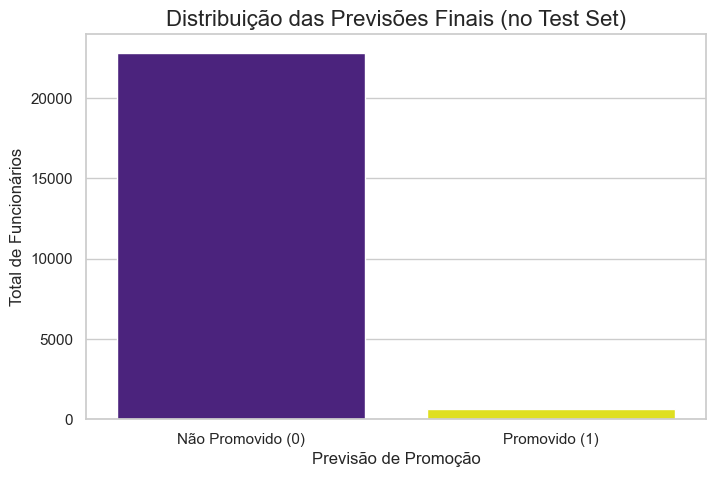


Contagem exata das previsões:
is_promoted
0    97.18%
1     2.82%
Name: proportion, dtype: object

--- Visualização 2: Perfil dos Grupos Previstos ---


C:\Users\loren\AppData\Local\Temp\ipykernel_9656\3321376190.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Não Promovido (0)', 'Promovido (1)'])
C:\Users\loren\AppData\Local\Temp\ipykernel_9656\3321376190.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Não Promovido (0)', 'Promovido (1)'])


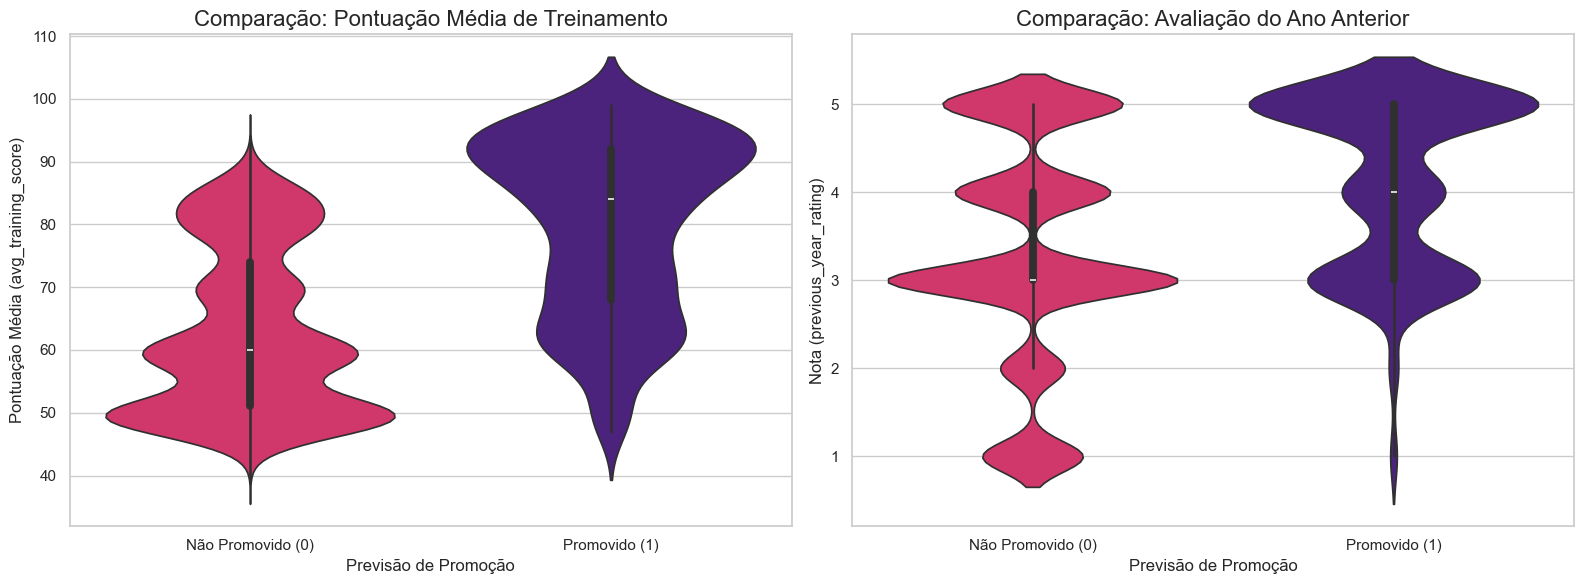

In [11]:
# Define o estilo padrão para os gráficos
sns.set(style="whitegrid")

# ==============================================================================
# VISUALIZAÇÃO 1: Distribuição das Previsões Finais (Gráfico de Barras)
# ==============================================================================

# Cores (Roxo e Amarelo)
palette_count = {0: "#4A148C", 1: "#FFFF00"} # Usar dicionário é mais robusto

print("--- Visualização 1: Distribuição das Previsões ---")
plt.figure(figsize=(8, 5))

# --- CORREÇÃO (FutureWarning) ---
ax1 = sns.countplot(
    x='is_promoted', 
    data=submission_df, 
    hue='is_promoted',    # 1. Atribui a variável ao 'hue'
    palette=palette_count,# 2. Passa o dicionário de cores
    legend=False          # 3. Esconde a legenda
)
# ------------------------------

ax1.set_title('Distribuição das Previsões Finais (no Test Set)', fontsize=16)
ax1.set_xlabel('Previsão de Promoção', fontsize=12)
ax1.set_ylabel('Total de Funcionários', fontsize=12)
ax1.set_xticklabels(['Não Promovido (0)', 'Promovido (1)'])

plt.show()

print("\nContagem exata das previsões:")
print(submission_df['is_promoted'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')


# ==============================================================================
# VISUALIZAÇÃO 2: Comparação de Perfis (Gráficos de Violino)
# ==============================================================================

# Cores (Magenta e Roxo)
palette_violin = {
    0: "#E91E63",
    1: "#4A148C"
}

# Cria um DataFrame temporário
viz_df = X_test.copy()

# --- CORREÇÃO (ValueError) ---
# Força a coluna de previsões a ser do tipo integer
viz_df['predicted_promotion'] = final_predictions.astype(int)
# -----------------------------

print("\n--- Visualização 2: Perfil dos Grupos Previstos ---")

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 6))

# --- Gráfico 2a: Pontuação Média de Treinamento ---
# --- CORREÇÃO (FutureWarning) ---
sns.violinplot(
    x='predicted_promotion', 
    y='avg_training_score', 
    data=viz_df, 
    hue='predicted_promotion', # 1. Atribui a variável ao 'hue'
    palette=palette_violin,
    legend=False,              # 2. Esconde a legenda
    ax=ax2
)
# ------------------------------
ax2.set_title('Comparação: Pontuação Média de Treinamento', fontsize=16)
ax2.set_xlabel('Previsão de Promoção', fontsize=12)
ax2.set_ylabel('Pontuação Média (avg_training_score)', fontsize=12)
ax2.set_xticklabels(['Não Promovido (0)', 'Promovido (1)'])


# --- Gráfico 2b: Avaliação do Ano Anterior ---
# --- CORREÇÃO (FutureWarning) ---
sns.violinplot(
    x='predicted_promotion', 
    y='previous_year_rating', 
    data=viz_df, 
    hue='predicted_promotion', # 1. Atribui a variável ao 'hue'
    palette=palette_violin,
    legend=False,              # 2. Esconde a legenda
    ax=ax3
)
# ------------------------------
ax3.set_title('Comparação: Avaliação do Ano Anterior', fontsize=16)
ax3.set_xlabel('Previsão de Promoção', fontsize=12)
ax3.set_ylabel('Nota (previous_year_rating)', fontsize=12)
ax3.set_xticklabels(['Não Promovido (0)', 'Promovido (1)'])

plt.tight_layout()
plt.show()

## 6. Verificação de precisão

--- Re-treinando o modelo em 80% dos dados para validar nos outros 20% ---

RELATÓRIO DE CLASSIFICAÇÃO (VALIDAÇÃO)
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10028
           1       0.80      0.28      0.42       934

    accuracy                           0.93     10962
   macro avg       0.87      0.64      0.69     10962
weighted avg       0.93      0.93      0.92     10962

--- Matriz de Confusão ---


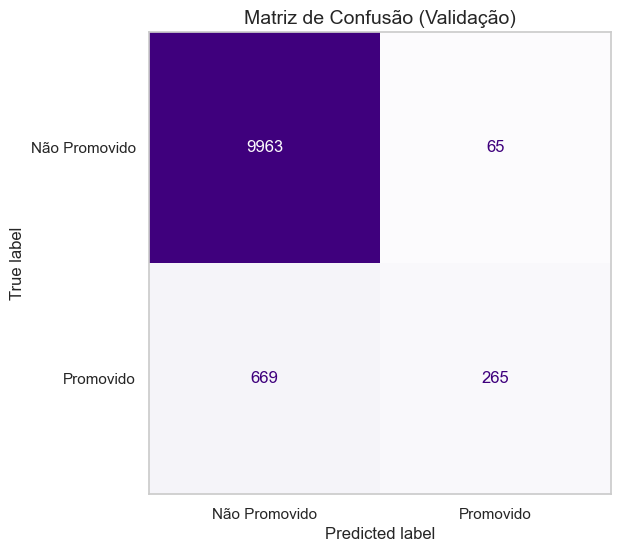

Legenda:
Verdadeiro Negativo (Top-Esq): O modelo acertou que não seria promovido.
Falso Positivo (Top-Dir): O modelo disse que seria promovido, mas NÃO foi (Erro tipo 1).
Falso Negativo (Inf-Esq): O modelo disse que NÃO seria, mas FOI promovido (Pior erro para retenção de talentos).
Verdadeiro Positivo (Inf-Dir): O modelo acertou a promoção.


In [12]:

# 1. Criar um conjunto de Validação (Hold-out) a partir do Treino original
# Usamos 'stratify=y_train' para garantir que a proporção de promovidos (3%) seja mantida
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print("--- Re-treinando o modelo em 80% dos dados para validar nos outros 20% ---")
# Usando seu pipeline já existente (pipe_rf_full ou search_results['hist_gb']['best_model'])
model_to_test = pipe_rf_full  # Ou substitua pelo seu modelo tunado
model_to_test.fit(X_train_split, y_train_split)

# 2. Fazer previsões na base de validação (onde sabemos a resposta correta)
y_pred_val = model_to_test.predict(X_val)

# 3. Exibir Relatório de Classificação (Foca na precisão da classe 1)
print("\n==================================================")
print("RELATÓRIO DE CLASSIFICAÇÃO (VALIDAÇÃO)")
print("==================================================")
print(classification_report(y_val, y_pred_val))

# 4. Matriz de Confusão Visual
print("--- Matriz de Confusão ---")
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Promovido', 'Promovido'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Purples', ax=ax, colorbar=False)
plt.title("Matriz de Confusão (Validação)", fontsize=14)
plt.grid(False)
plt.show()

# Explicação rápida para o usuário
print(f"Legenda:")
print(f"Verdadeiro Negativo (Top-Esq): O modelo acertou que não seria promovido.")
print(f"Falso Positivo (Top-Dir): O modelo disse que seria promovido, mas NÃO foi (Erro tipo 1).")
print(f"Falso Negativo (Inf-Esq): O modelo disse que NÃO seria, mas FOI promovido (Pior erro para retenção de talentos).")
print(f"Verdadeiro Positivo (Inf-Dir): O modelo acertou a promoção.")

## 7. Conclusão e Próximos Passos: A Oportunidade EVOLUTI

A análise do nosso modelo de previsão revela um diagnóstico fundamental sobre o estado atual da progressão de carreira na organização.

Ao aplicar o modelo no conjunto de dados de teste (a base intocada), as previsões finais mostraram a seguinte distribuição:

| Previsão | Percentual dos Funcionários |
| :--- | :--- |
| **Não Promovido (0)** | **97,18%** |
| **Promovido (1)** | **2,82%** |

Este número, **apenas 2,82%** de funcionários sendo previstos como aptos à promoção, é um indicador claro de que a progressão de carreira é um desafio central.

### A Conexão com o Projeto EVOLUTI

Este resultado não é um beco sem saída; é uma oportunidade.

Anteriormente, nossa análise de **Feature Importance** (na Célula 5) provou que as variáveis mais decisivas para uma promoção são o **`avg_training_score`** (desempenho em treinamentos) e o **`previous_year_rating`** (avaliação de desempenho).

Com uma previsão tão baixa de promoções, fica evidente que a estratégia mais eficaz é criar uma intervenção que estimule exatamente esses dois pilares.

É aqui que o projeto **EVOLUTI** se torna a solução estratégica. O EVOLUTI é projetado para atacar diretamente essa questão, utilizando a **gamificação** como motor para incentivar a **capacitação** contínua e a melhoria do **desempenho**.

Portanto, este modelo de Machine Learning não apenas prevê um resultado, mas valida a necessidade de um projeto como o EVOLUTI para ajudar a empresa a aumentar ativamente esses números, transformando potencial em performance reconhecida.

----

----

